In [177]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import re
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mlines
from matplotlib import colors as mcolors
import matplotlib.backends.backend_pdf
import matplotlib.font_manager as font_manager
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [246]:
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'System San Francisco Display Regular', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'System San Francisco Display Bold', 'size':'14'}
font_path = "/global/homes/t/tkurth/fonts/System San Francisco Display Thin.ttf"
font_path_bf = "/global/homes/t/tkurth/fonts/System San Francisco Display Regular.ttf"
font_prop_title = font_manager.FontProperties(fname=font_path, size=40)
font_prop_axis = font_manager.FontProperties(fname=font_path, size=30)
font_prop_axis_labels = font_manager.FontProperties(fname=font_path, size=40)
font_prop_legend = font_manager.FontProperties(fname=font_path, size=26)
font_prop_legend_small = font_manager.FontProperties(fname=font_path, size=24)

#markers
lw = 4
ms = 200
colorlist = ['crimson','dodgerblue','darkorchid','forestgreen','goldenrod','silver','darkorange','turquoise'] \
            +[str(name) for name,hex in mcolors.cnames.items()]
markerlist = ['v','s','o','*','^','x','p','8','+','>','<']
xoff = 0.
xwidth = 0.4
xshift = 0.1

## General Functions

In [247]:
def parse_file(filename):
    token = re.findall(R"(.*?)_ngpu(.*?).out", os.path.basename(filename))[0]
    
    record = {"num_gpus": int(token[1]),
              "features": token[0]
             }
    
    with open(filename, "r") as f:
        lines = f.readlines()
    
    pattern = re.compile(R"Run (.*?): iterations took (.*?)s for (.*?) iterations")
    recordlist = []
    for line in lines:
        p = pattern.match(line)
        if p is not None:
            pg = p.groups()
            record = {"num_gpus": int(token[1]),
                      "feature": token[0],
                      "run": int(pg[0]),
                      "total_time": float(pg[1]),
                      "num_iterations": int(pg[2])
                     }
            recordlist.append(record)
    
    return pd.DataFrame(recordlist)

## Load Data

In [251]:
data_dir = "./results"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".out")]

dflist = []
for filename in files:
    dflist.append(parse_file(filename))

datadf = pd.concat(dflist)
datadf["samples_per_second"] = datadf["num_iterations"] * datadf["num_gpus"] / datadf["total_time"]

## Analysis

In [252]:
# we sort using these keys
selectkeys = ["feature", "num_gpus"]

resultdf = datadf[selectkeys + ["samples_per_second"]].groupby(selectkeys).agg(["mean","std"]).reset_index()
resultdf.sort_values(by=selectkeys, inplace=True)

## Plot

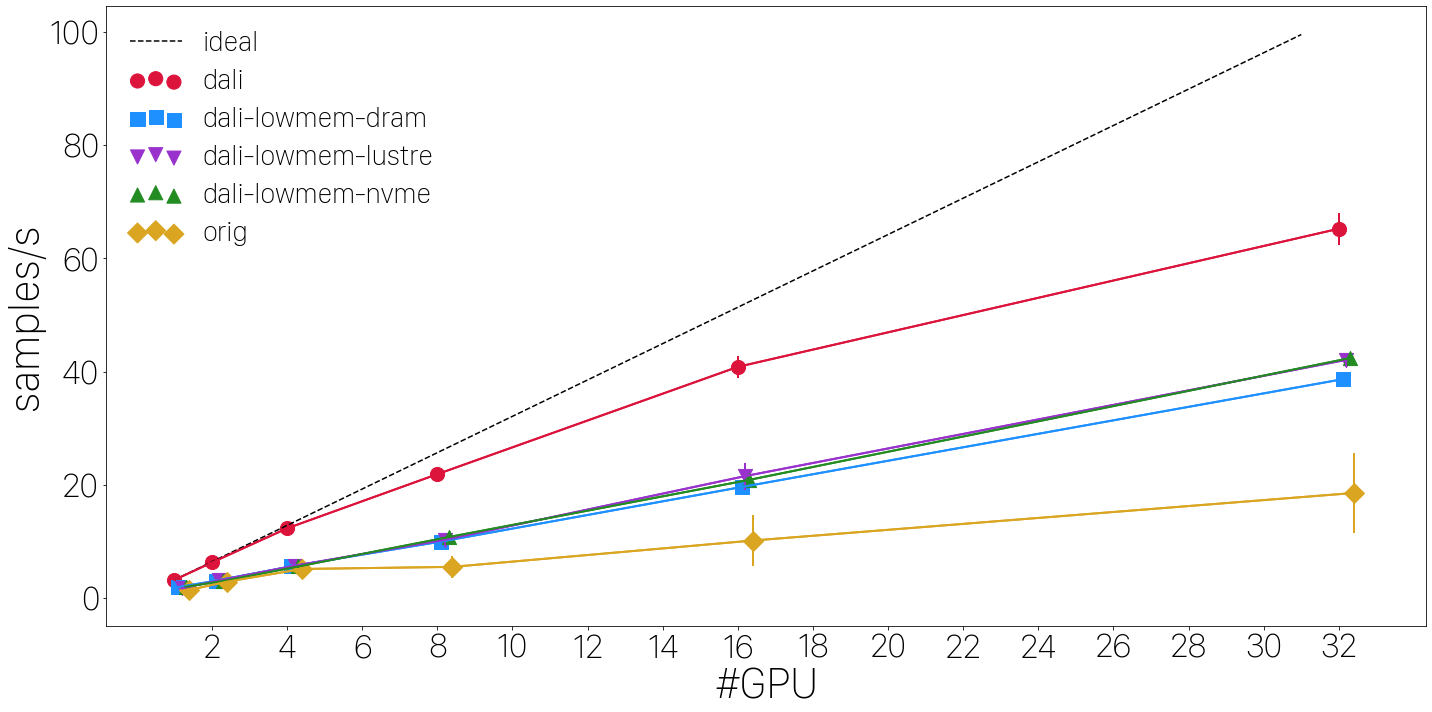

In [254]:
numrows = 1
numcols = 1
fig, ax = plt.subplots(figsize=(20*numcols, 10*numrows), nrows=numrows, ncols=numcols)
ax.set_xlabel('#GPU',fontproperties=font_prop_axis_labels)
ax.set_ylabel('samples/s',fontproperties=font_prop_axis_labels)
ax.set_xticks(np.arange(2,34,2))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontproperties(font_prop_axis)
        label.set_fontsize(32)

for idx, feature in enumerate(resultdf["feature"].unique()):
    selectdf = resultdf[ resultdf["feature"] == feature ]
    ax.plot(selectdf["num_gpus"].values + xshift * idx, 
            selectdf["samples_per_second"]["mean"].values, 
            lw=2,
            color=colorlist[idx])
    ax.scatter(selectdf["num_gpus"].values + xshift * idx, 
                selectdf["samples_per_second"]["mean"].values,
                s=ms,
                marker=styles[idx],
                color=colorlist[idx],
                label=feature)
    ax.errorbar(selectdf["num_gpus"].values + xshift * idx, 
                selectdf["samples_per_second"]["mean"].values, 
                selectdf["samples_per_second"]["std"].values,
                lw=2,
                color=colorlist[idx])

#ideal
best_slope = resultdf.loc[resultdf["num_gpus"] == 1, "samples_per_second"]["mean"].values[0]
xvals = np.arange(1, 32, 1.)
yvals = np.array([x*best_slope for x in xvals])
ax.plot(xvals, yvals, ls = "--", color = "k", label="ideal")

#legend
ax.legend(loc='upper left', ncol=1, scatterpoints=3, frameon = False, prop=font_prop_legend)

# save the plot
plt.tight_layout()
plt.savefig('./pipeline_scaling.png')